## A life-cycle consumption  problem nder objective/subjective risk perceptions

- author: Tao Wang
- date: September 2021
- this is a companion notebook to the paper "Perceived income risks"

- This notebook builds on a standard life-cycle consumption model under an incomplete market and extends it to allow subjective belief formation about income risks
  - Preference/income process

      - CRRA utility 
      - During work: labor income risk: permanent + MA(1)/persistent/transitory/2-state Markov between UE and EMP or between low and high risk + i.i.d. unemployment shock
       -  a deterministic growth rate of permanent income over the life cycle 
      - During retirement: receives a constant pension proportional to permanent income (hence still subject to permanent income risks)
      - A positive probability of death before terminal age 
  

- Objective v.s. subjective
     - All state variables are obsersable: permanent income, ma(1) shock or the persistent shock
     - What may not be perfectly known is the size and nature of the risks 
  1. Perfect understanding case
  2. Benchmark case without perfect understanding
      - individual observe past income realizations
      - overreact to transitory shock realizations
          - perceived risk of transitory shock is a weighted average of long-run mean and short-run deviations
          - similarly, the same mechanism can be for permanent risks 
      - individuals swing between low and high risk perceptions (either about permanent or transitory income risks) following a 2-state Markov 

- Other bolder extensions
  - Extention 1
       - subjective determine the degree of persistence or the ma(1) coefficient 
       - assymetric extrolation 
      
  - Extention 2 
       - adding aggregate risks, and agents need to learn about the growth rate using cross-sectional experiences
       - so subjectively determine the cross-sectional correlation
       - form the best guess and the corresponding uncertainty based on the attribution
         
  - Extenstion 3
       - persistence attribution is assymmetric: determined by realized income shocks 
       - correlation attribution is assymetric: determined by realized income shocks 

In [1]:
import numpy as np
import pandas as pd
from quantecon.optimize import brent_max, brentq
from interpolation import interp, mlinterp
from scipy import interpolate
import numba as nb
from numba import jit,njit, float64, int64, boolean
from numba.experimental import jitclass
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
import quantecon as qe 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from time import time
#from HARK.utilities import make_grid_exp_mult
from scipy import sparse as sp
import scipy.sparse.linalg
from scipy import linalg as lg 
from numba.typed import List
from Utility import cal_ss_2markov

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
## figure plotting configurations

mp.rc('xtick', labelsize=11) 
mp.rc('ytick', labelsize=11) 

mp.rc('legend',fontsize=11)
plt.rc('font',size=11) 

## The Model Class and Solver

In [3]:
lc_data = [
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Nominal interest rate factor 
    ('W',float64),               # Wage rate
    ('P', float64[:, :]),        # transition probs for z_t, a persistent (macro) state  x
    ('z_val', float64[:]),       # values of z, grid values for the continous (macro) persistent state    x
    ('sigma_n', float64),        # permanent shock volatility              x
    ('x',float64),               # MA(1) coefficient, or essentially the autocorrelation coef of non-persmanent income
    ('sigma_eps', float64),      # transitory shock volatility
    ('borrowing_cstr',boolean),  ## artifitial borrowing constraint, natural borrowing constraint if False
    ('U',float64),               # the probability of being unemployed    * 
    ('LivPrb',float64),         # the probability of being alive next period 
    ('b_y', float64),            # loading of macro state to income        x 
    ('sigma_n_2mkv',float64[:]), # markov permanent risks, only 2 for now
    ('sigma_eps_2mkv',float64[:]), # markov transtory risk, only 2 for now
    ('s_grid', float64[:]),      # Grid over savings
    ('eps_grid', float64[:]),    # Grid over savings
    ('n_shk_draws', float64[:]), ## Draws of permanent income shock 
    ('eps_shk_draws', float64[:]), # Draws of MA/transitory income shocks 
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64[:]),            # growth rate of permanent income    *
    ('theta',float64),           ## extrapolation parameter 
    ('shock_draw_size',int64),    ## nb of points drawn for shocks 
    ('n_shk_mkv_draws',float64[:,:]),  ## 2-state markov on permanent risks 
    ('eps_shk_mkv_draws',float64[:,:]), ## 2-state markov on transitory risks
    ('unemp_insurance',float64),   ## Unemployment insurance replacement ratio 
    ('pension',float64),           ## pension payment to permanent income ratio
    ('ue_markov', boolean),        ## True if 2-state emp/uemp markov 
    ('adjust_prob',float64),        ## the exogenous probability of being able to adjust consumption plan 
    ('sigma_p_init',float64),         ## standard devaition of initial income
    ('init_p_draws', float64[:]),     ## Draws of initial permanent income 
    ('init_b', float64),              ## Initial endowment (possibly from accidental bequests) 
    ('λ', float64),                   ## Income tax rate
    ('λ_SS',float64),                 ## Social security tax 
    ('transfer', float64),            ## Transfer/current permanent income ratio
    ('bequest_ratio',float64)         ## zero: bequest thrown to the ocea; one: fully given to newborns
]

In [4]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption problem.
    """

    def __init__(self,
                 ρ = 1.0,     ## relative risk aversion  
                 β = 0.99,  ## discount factor
                 P = np.array([[0.9,0.1],
                              [0.2,0.8]]),   ## transitory probability of markov state z
                 z_val = np.array([0.0,
                                   1.0]), ## markov state from low to high  
                 sigma_n = 0.10,     ## size of permanent income shocks
                 sigma_eps = 0.10,   ## size of transitory income risks
                 x = 0.0,            ## MA(1) coefficient of non-permanent inocme shocks
                 borrowing_cstr = True,  ## artificial zero borrowing constraint 
                 U = 0.0,   ## unemployment risk probability (0-1)
                 LivPrb = 0.995,       ## living probability 
                 b_y = 0.0,          ## loading of markov state on income  
                 sigma_n_2mkv = np.array([0.05,0.2]),  ## permanent risks in 2 markov states
                 sigma_eps_2mkv = np.array([0.08,0.12]),  ## transitory risks in 2 markov states
                 R = 1.02,           ## interest factor 
                 W = 1.0,            ## Wage rate
                 T = 40,             ## work age, from 25 to 65
                 L = 60,             ## life length 85
                 G = np.ones(60),    ## growth factor list of permanent income 
                 shock_draw_size = 40,
                 grid_max = 2.5,
                 grid_size = 50,
                 seed = 456789,
                 theta = 2,               ## assymetric extrapolative parameter
                 unemp_insurance = 0.15,   #  unemp_insurance = 0.0,   
                 pension = 1.0,           
                 ue_markov = False,    
                 adjust_prob = 1.0,
                 sigma_p_init = 0.0,
                 init_b = 0.0,
                 λ = 0.10,
                 λ_SS = 0.1,
                 transfer = 0.0,
                 bequest_ratio = 0.0):  

        np.random.seed(seed)  # arbitrary seed
        
        self.ρ, self.β = ρ, β
        self.R = R 
        self.W = W
        n_z = len(z_val)
        self.P, self.z_val = P, z_val
        n_mkv = len(sigma_n_2mkv)
        assert n_z == n_mkv, "the number of markov states for income and for risks should be equal"
        self.T,self.L = T,L
        self.G = G
        self.sigma_n = sigma_n
        self.x = x
        self.sigma_eps = sigma_eps
        self.sigma_p_init = sigma_p_init
        self.init_b = init_b
        self.borrowing_cstr = borrowing_cstr
        self.b_y = b_y
        self.λ = λ
        self.λ_SS= λ
        self.transfer = transfer 
        self.bequest_ratio = bequest_ratio 
        self.sigma_n_2mkv = sigma_n_2mkv
        self.sigma_eps_2mkv = sigma_eps_2mkv
        self.LivPrb = LivPrb 
        self.unemp_insurance = unemp_insurance
        self.pension = pension 
        self.ue_markov = ue_markov
        self.adjust_prob = adjust_prob
        
        
        ## shocks 
        
        self.shock_draw_size = shock_draw_size
        
        ## these codes use equalprob discretized distributions at the cost of not being jittable 
        
        #mu_n = -sigma_n**2/2
        #mu_eps = -sigma_eps**2/2
        #theta_n = stats.lognorm(sigma_n, 0, np.exp(mu_n))    # Create "frozen" distribution instance
        #theta_eps = stats.lognorm(sigma_eps, 0, np.exp(mu_eps)) # Create "frozen" distribution instance
        #self.n_shk_draws = DiscreteApproximation(N = shock_draw_size, 
        #                                         cdf=theta_n.cdf, 
        #                                         pdf=theta_n.pdf, 
        #                                         invcdf=theta_n.ppf)
        #self.eps_shk_draws = DiscreteApproximation(N = shock_draw_size, 
        #                                         cdf=theta_eps.cdf, 
        #                                         pdf=theta_eps.pdf, 
        #                                         invcdf=theta_eps.ppf)
        
        
        ## draw shocks for constant volatility scenario
        self.n_shk_draws = sigma_n*np.random.randn(shock_draw_size)-sigma_n**2/2
        self.eps_shk_draws = sigma_eps*np.random.randn(shock_draw_size)-sigma_eps**2/2
        self.init_p_draws = sigma_p_init*np.random.randn(shock_draw_size)-sigma_p_init**2/2
        
        ## draw shocks for stochastic volatility scenario
        sigma_n_2mkv_r = sigma_n_2mkv.reshape(n_mkv,-1)
        sigma_eps_2mkv_r = sigma_eps_2mkv.reshape(n_mkv,-1)
        
        self.n_shk_mkv_draws = sigma_n_2mkv_r*np.random.randn(shock_draw_size)-sigma_n_2mkv_r**2/2
        self.eps_shk_mkv_draws = sigma_eps_2mkv_r*np.random.randn(shock_draw_size)-sigma_eps_2mkv_r**2/2

        
        ## ma(1) shock grid 
        lb_sigma_ϵ = -sigma_eps**2/2-2*sigma_eps
        ub_sigma_ϵ = -sigma_eps**2/2+2*sigma_eps
        self.eps_grid = np.linspace(lb_sigma_ϵ,ub_sigma_ϵ,grid_size)
        
        ## saving grid
        self.s_grid = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size))
       
       
        ## extrapolaton coefficient, i.e. higher theta, higher asymmetric response
        self.theta = theta
        
        # Test stability 
        ## this is for infinite horizon problem 
        #assert β * R < 1, "Stability condition failed."

    ## utility function 
    def u(self,c):
        return c**(1-self.ρ)/(1-ρ)
    
    # Marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)
    
    ## value function 
    def V(self,m):
        return None

    def Y(self, z, u_shk):
        #from the transitory/ma shock and ue realization  to the income factor
        if self.ue_markov ==False:
            ## z state continuously loading to inome
            ## u_shk here represents the cumulated MA shock, for instance, for ma(1), u_shk = phi eps_(t-1) + eps_t
            ## income 
            return np.exp(u_shk + (z * self.b_y))
        elif self.ue_markov ==True:
            assert len(self.P)==2,"unemployment/employment markov has to be 2 state markov"
            return (z==0)*(self.unemp_insurance) + (z==1)*np.exp(u_shk)

    def Γ(self,n_shk):
        ## from the permanent shock to the income factor
        return np.exp(n_shk)

In [5]:
## this function takes the consumption values at different grids of state 
###   variables from period t+1, and model class 
### and generates the consumption values at t 

@njit
def EGM(aϵ_in,
      σ_in,
      t, ## the period for which the c policy is computed 
      lc):
    """
    The Coleman--Reffett operator for the life-cycle consumption problem,
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * aϵ_in is the same sized grid points of the three state variable 
        * aϵ_in[:,j,z] is the vector of asset grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    W = lc.W
    z_val = lc.z_val
    s_grid,eps_grid = lc.s_grid,lc.eps_grid
    n_shk_draws, eps_shk_draws= lc.n_shk_draws, lc.eps_shk_draws
    borrowing_cstr = lc.borrowing_cstr 
    ue_prob = lc.U  ## uemp prob
    LivProb = lc.LivPrb  ## live probabilituy 
    unemp_insurance = lc.unemp_insurance
    ue_markov = lc.ue_markov            ## bool for 2-state markov transition probability 
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability 
     
    Y = lc.Y
    ####################
    ρ = lc.ρ
    Γ = lc.Γ
    ####################################
    G = lc.G[t+1]  ## get the age specific 
    ####################################

    x = lc.x
    λ = lc.λ
    λ_SS = lc.λ_SS
    transfer = lc.transfer
    
    ###################
    
    n = len(P)

    # Create consumption function by linear interpolation
    ########################################################
    σ = lambda a,ϵ,z: mlinterp((aϵ_in[:,0,z],eps_grid),σ_in[:,:,z], (a,ϵ)) 
    ########## need to replace with multiinterp 

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_s X grid_size_ϵ X grid_size_z

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    for eps_shk in eps_shk_draws:
                        for n_shk in n_shk_draws:
                            ## for employed next period 
                            Γ_hat = Γ(n_shk) 
                            u_shk = x*eps+eps_shk
                            if t <=lc.T-1:
                                ## work 
                                Y_hat = (1-λ)*(1-λ_SS)*Y(z_val_hat,u_shk) ## conditional on being employed 
                                c_hat = σ(R/(G*Γ_hat) * s + Y_hat+transfer/(G*Γ_hat),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)

                                ## for unemployed next period
                                Y_hat_u = (1-λ)*unemp_insurance
                                c_hat_u = σ(R/(G*Γ_hat) * s + Y_hat_u+transfer/(G*Γ_hat),eps_shk,z_hat)
                                utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                            
                                Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                           ue_prob*utility_u* P[z, z_hat]
                                          )
                            else:
                                ## retirement
                                Y_R = lc.pension
                                ## no income shcoks affecting individuals 
                                Γ_hat = 1.0 
                                eps_shk = 0.0
                                c_hat = σ(R/(G*Γ_hat) * s + (Y_R+transfer)/(G*Γ_hat),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                Ez += LivProb*utility * P[z, z_hat]
                            
                Ez = Ez / (len(n_shk_draws)*len(eps_shk_draws))
                ## the last step depends on if adjustment is fully flexible
                if adjust_prob ==1.0:
                    σ_out[i, j, z] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <1.0:
                    σ_out[i, j, z] =  adjust_prob/(1-LivProb*β*R*(1-adjust_prob))*u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    aϵ_out = np.empty_like(σ_out)

    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            aϵ_out[:,j,z] = s_grid + σ_out[:,j,z]

    # Fixing a consumption-asset pair at for the constraint region
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_out[0,j,z] = 0.0
                aϵ_out[0,j,z] = 0.0
            #elif borrowing_cstr==False and ue_markov==True:
            #    σ_out[0,j,z] = 0.0
            #    aϵ_out[0,j,z] = min(0.0,-unemp_insurance/R)
            else:
                σ_out[0,j,z] = 0.0
                self_min_a = - np.exp(np.min(eps_grid))*G/R
                self_min_a = min(self_min_a,-unemp_insurance/R)
                aϵ_out[0,j,z] = self_min_a

    return aϵ_out, σ_out

In [6]:
## the operator under markov stochastic risks 
## now the permanent and transitory risks are different between a good macro and bad macro state 

@njit
def EGM_sv(aϵ_in, 
         σ_in, 
         t,
         lc):
    """
    The Coleman--Reffett operator for the life-cycle consumption problem,
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * aϵ_in is the same sized grid points of the three state variable 
        * aϵ_in[:,j,z] is the vector of asset grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    z_val = lc.z_val
    s_grid,eps_grid = lc.s_grid,lc.eps_grid
    n_shk_draws, eps_shk_draws= lc.n_shk_draws, lc.eps_shk_draws
    borrowing_cstr = lc.borrowing_cstr
    ue_prob = lc.U  ## uemp prob
    unemp_insurance = lc.unemp_insurance
    LivProb = lc.LivPrb  ## live probabilituy
    ue_markov = lc.ue_markov
    n_shk_mkv_draws, eps_shk_mkv_draws = lc.n_shk_mkv_draws, lc.eps_shk_mkv_draws 
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability 
    Y = lc.Y
    ####################
    ρ = lc.ρ
    Γ = lc.Γ
    ####################################
    G = lc.G[t+1]  ## get the age specific 
    ####################################    
    x = lc.x
    λ = lc.λ
    transfer = lc.transfer
    pension = lc.pension
    
    ###################
    T = lc.T
    L = lc.L
    
    ###################
    n = len(P)

    # Create consumption function by linear interpolation
    ########################################################
    σ = lambda a,ϵ,z: mlinterp((aϵ_in[:,0,z],eps_grid),σ_in[:,:,z], (a,ϵ)) 
    ########## need to replace with multiinterp 

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_s X grid_size_ϵ X grid_size_z

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    n_shk_draws = n_shk_mkv_draws[z_hat,:]
                    eps_shk_draws = eps_shk_mkv_draws[z_hat,:]
                    for eps_shk in eps_shk_draws:
                        for n_shk in n_shk_draws:
                            Γ_hat = Γ(n_shk) 
                            u_shk = x*eps+eps_shk
                            if t <=lc.T-1:
                                # work  
                                Y_hat = (1-λ)*Y(z_val_hat,u_shk) ## conditional on being employed 
                                c_hat = σ(R/(G*Γ_hat) * s + Y_hat+transfer/(G*Γ_hat),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)

                                ## for unemployed next period
                                Y_hat_u = (1-λ)*unemp_insurance
                                c_hat_u = σ(R/(G*Γ_hat) * s + Y_hat_u+transfer/(G*Γ_hat),eps_shk,z_hat)
                                utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                                Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                               ue_prob*utility_u* P[z, z_hat]
                                              )
                            else:
                                ## retirement
                                Y_R = lc.pension
                                ## no income shcoks affecting individuals 
                                Γ_hat = 1.0 
                                eps_shk = 0.0
                                c_hat = σ(R/(G*Γ_hat) * s + (Y_R+transfer)/(G*Γ_hat),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                Ez += LivProb*utility * P[z, z_hat]
                Ez = Ez / (len(n_shk_draws)*len(eps_shk_draws))
                ## the last step depends on if adjustment is fully flexible
                if adjust_prob ==1.0:
                    σ_out[i, j, z] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <=1.0:
                    σ_out[i, j, z] =  adjust_prob/(1-β*R*(1-adjust_prob))*u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    aϵ_out = np.empty_like(σ_out)
                
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            aϵ_out[:,j,z] = s_grid + σ_out[:,j,z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_out[0,j,z] = 0.0
                aϵ_out[0,j,z] = 0.0
            #elif borrowing_cstr==True or ue_markov==True:
            #    print('case2')
            #    σ_out[0,j,z] = 0.0
            #    aϵ_out[0,j,z] = min(0.0,-unemp_insurance/R)
            else:
                if t <=T-1:
                    σ_out[0,j,z] = 0.0
                    self_min_a = - np.exp(np.min(eps_grid))*G/R
                    self_min_a = min(self_min_a,-unemp_insurance/R)
                    aϵ_out[0,j,z] = self_min_a
                else:
                    σ_out[0,j,z] = 0.0
                    self_min_a = - pension*G/R
                    aϵ_out[0,j,z] = self_min_a


    return aϵ_out, σ_out

In [7]:
## this function describes assymetric extrapolative rule from realized income shock to the perceived risk 

@njit
def extrapolate(theta,
                x,
                eps_shk):
    """
    extrapolation function from realized eps_shk from unbiased risk x to the subjective risk x_sub
    x_sub = x when eps_shk = 0  
    theta governs the degree of extrapolation 
    """
    if x ==0.0:
        alpha=0.0
    else:
        alpha=np.log((1-x)/x) ## get the alpha for unbiased x
    x_sub = 1/(1+np.exp(alpha-theta*eps_shk))
    return x_sub

In [8]:
## subjective agent
### transitory shock affects risk perceptions

@njit
def EGM_br(aϵ_in, 
         σ_in, 
         t,
         lc):
    """
    UNDER BOUNDED RATIONALITY assumption
    The Coleman--Reffett operator for the life-cycle consumption problem. 
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * aϵ_in is the same sized grid points of the three state variable 
        * aϵ_in[:,j,z] is the vector of asset grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    z_val = lc.z_val
    s_grid,eps_grid = lc.s_grid,lc.eps_grid
    n_shk_draws, eps_shk_draws= lc.n_shk_draws, lc.eps_shk_draws
    borrowing_cstr = lc.borrowing_cstr
    ue_prob = lc.U  ## uemp prob
    unemp_insurance = lc.unemp_insurance
    LivProb = lc.LivPrb  ## live probabilituy
    ue_markov = lc.ue_markov
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability 
    Y = lc.Y
    ####################
    ρ = lc.ρ
    Γ = lc.Γ
    G = lc.G
    ####################################
    G = lc.G[t+1]  ## get the age specific 
    ####################################  
    x = lc.x
    λ = lc.λ
    transfer = lc.transfer
    pension = lc.pension
    
    ###################
    T = lc.T
    L = lc.L
    
    ###################
    theta = lc.theta 
    sigma_eps = lc.sigma_eps
    eps_mean = -sigma_eps**2/2
    ###################
    
    n = len(P)

    # Create consumption function by linear interpolation
    ########################################################
    σ = lambda a,ϵ,z: mlinterp((aϵ_in[:,0,z],eps_grid),σ_in[:,:,z], (a,ϵ)) 
    ########## need to replace with multiinterp 

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_s X grid_size_ϵ X grid_size_z

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for j, eps in enumerate(eps_grid):
            ##############################################################
            #x_sj = extrapolate(theta,
            #                   lc.x,
            #                   eps-eps_mean) ## sj: subjective 
            sigma_eps_sj = 0.05*np.sqrt((eps-eps_mean)**2)+0.95*lc.sigma_eps
            np.random.seed(166789)
            eps_shk_draws_sj = sigma_eps_sj*np.random.randn(lc.shock_draw_size)-sigma_eps_sj**2/2
            #############################################################
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    ################################
                    for eps_shk in eps_shk_draws_sj:
                        ############################
                        for n_shk in n_shk_draws:
                            Γ_hat = Γ(n_shk) 
                            ###############
                            u_shk = x*eps+eps_shk
                            ####################
                            if t <=lc.T-1:
                                # work  
                                Y_hat = (1-λ)*Y(z_val_hat,u_shk) ## conditional on being employed 
                                c_hat = σ(R/(G*Γ_hat) * s + Y_hat+transfer/(G*Γ_hat),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)

                                ## for unemployed next period
                                Y_hat_u = (1-λ)*unemp_insurance
                                c_hat_u = σ(R/(G*Γ_hat) * s + Y_hat_u+transfer/(G*Γ_hat) ,eps_shk,z_hat)
                                utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                                Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                               ue_prob*utility_u* P[z, z_hat]
                                              )
                            else:
                                
                                ## retirement
                                Y_R = lc.pension
                                ## no income shcoks affecting individuals 
                                Γ_hat = 1.0 
                                eps_shk = 0.0
                                c_hat = σ(R/(G*Γ_hat) * s + (Y_R+transfer)/(G*Γ_hat),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                Ez += LivProb*utility * P[z, z_hat]
                Ez = Ez / (len(n_shk_draws)*len(eps_shk_draws_sj))
                ## the last step depends on if adjustment is fully flexible
                if adjust_prob ==1.0:
                    σ_out[i, j, z] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <=1.0:
                    σ_out[i, j, z] =  adjust_prob/(1-β*R*(1-adjust_prob))*u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    aϵ_out = np.empty_like(σ_out)
            
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            aϵ_out[:,j,z] = s_grid + σ_out[:,j,z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_out[0,j,z] = 0.0
                aϵ_out[0,j,z] = 0.0
            #elif borrowing_cstr==True or ue_markov==True:
            #    σ_out[0,j,z] = 0.0
            #    aϵ_out[0,j,z] = min(0.0,-unemp_insurance/R)
            else:
                if t <=T-1:
                    σ_out[0,j,z] = 0.0
                    self_min_a = - np.exp(np.min(eps_grid))*G/R
                    self_min_a = min(self_min_a,-unemp_insurance/R)
                    aϵ_out[0,j,z] = self_min_a
                else:
                    σ_out[0,j,z] = 0.0
                    self_min_a = - pension*G/R
                    aϵ_out[0,j,z] = self_min_a

    return aϵ_out, σ_out

In [9]:
## for life-cycle/finite horizon problem 
def solve_model_backward_iter(model,        # Class with model information
                                  aϵ_vec,        # Initial condition for assets and MA shocks
                                  σ_vec,        # Initial condition for consumption
                                  br = False,
                                  sv = False):

    ## memories for life-cycle solutions 
    n_grids1 = σ_vec.shape[0]
    n_grids2 =σ_vec.shape[1]
    n_z = len(model.P)                       
    aϵs_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    σs_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    
    aϵs_new[0,:,:,:] = aϵ_vec
    σs_new[0,:,:,:] = σ_vec
    
    for year2L in range(1,model.L): ## nb of years till L from 0 to Model.L-2
        age = model.L-year2L
        age_id = age-1
        print("at work age of "+str(age))
        aϵ_vec_next, σ_vec_next = aϵs_new[year2L-1,:,:,:],σs_new[year2L-1,:,:,:]
        if br==False:
            if sv ==False:
                print('objective model without stochastic risk')
                aϵ_new, σ_new =EGM(aϵ_vec_next, σ_vec_next, age_id, model)
            else:
                print('objective model with stochastic risk')
                aϵ_new, σ_new = EGM_sv(aϵ_vec_next, σ_vec_next, age_id, model)
        elif br==True:
            print('subjective model with stochastic risk')
            aϵ_new, σ_new = EGM_br(aϵ_vec_next, σ_vec_next, age_id, model)
        aϵs_new[year2L,:,:,:] = aϵ_new
        σs_new[year2L,:,:,:] = σ_new

    return aϵs_new, σs_new

In [10]:
## for infinite horizon problem 
def solve_model_iter(model,        # Class with model information
                     ae_vec,        # Initial condition for assets and MA shocks
                     σ_vec,        # Initial condition for consumption
                      tol=1e-6,
                      max_iter=2000,
                      verbose=True,
                      print_skip=50,
                      br = False,
                      sv = False):

    # Set up loop
    i = 0
    error = tol + 1

    ## memories for life-cycle solutions 
    n_grids1 = σ_vec.shape[0]
    n_grids2 =σ_vec.shape[1]
    n_z = len(model.P)                       
    
    while i < max_iter and error > tol:
        ae_new, σ_new = EGM(ae_vec, σ_vec, 0,model)
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        ae_vec, σ_vec = np.copy(ae_new), np.copy(σ_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return ae_vec, σ_vec

## Initialize the model

In [11]:
if __name__ == "__main__":


    ## parameters 
    ###################

    U = 0.2 ## transitory ue risk
    U0 = 0.0 ## transitory ue risk
    unemp_insurance = 0.15
    sigma_n = 0.05 # permanent 
    sigma_eps = 0.2 # transitory 


    #λ = 0.0  ## tax rate
    #λ_SS = 0.0 ## social tax rate
    #transfer = 0.0  ## transfer 
    #pension = 1.0 ## pension


    ## life cycle 

    T = 20
    L = 30
    TGPos = int(L/3) ## one third of life sees income growth 
    GPos = 1.01*np.ones(TGPos)
    GNeg= 0.99*np.ones(L-TGPos)
    #G = np.concatenate([GPos,GNeg])
    G = np.ones(L)
    YPath = np.cumprod(G)


    ## other parameters 

    ρ = 2
    R = 1.01
    β = 0.97
    x = 0.0
    theta = 0.0 ## extrapolation parameter 

    ## no persistent state
    b_y = 0.0

    ## wether to have zero borrowing constraint 
    borrowing_cstr = True

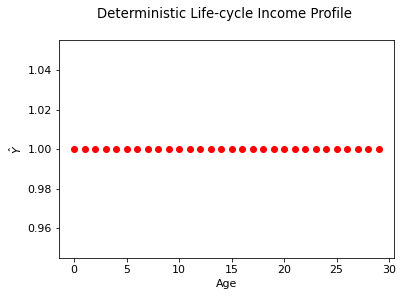

In [12]:
## a deterministic income profile 
if __name__ == "__main__":

    plt.title('Deterministic Life-cycle Income Profile \n')
    plt.plot(YPath,'ro')
    plt.xlabel('Age')
    plt.ylabel(r'$\hat Y$')

## Life-Cycle Problem 

### Consumption  the last period 

In [13]:
"""
## this is the retirement consumption policy 

def policyPF(β,
             ρ,
             R,
             T,
             L):
    c_growth = β**(1/ρ)*R**(1/ρ-1)
    return (1-c_growth)/(1-c_growth**(L-T))
    
"""

'\n## this is the retirement consumption policy \n\ndef policyPF(β,\n             ρ,\n             R,\n             T,\n             L):\n    c_growth = β**(1/ρ)*R**(1/ρ-1)\n    return (1-c_growth)/(1-c_growth**(L-T))\n    \n'

In [14]:
if __name__ == "__main__":
    lc = LifeCycle(sigma_n = sigma_n,
                   sigma_eps = sigma_eps,
                   U=U,
                   ρ=ρ,
                   R=R,
                   T=T,
                   L=L,
                   G=G,
                   β=β,
                   x=x,
                   borrowing_cstr = borrowing_cstr,
                   b_y=b_y,
                   unemp_insurance = unemp_insurance,
                   )

In [15]:
# Initial the end-of-period consumption policy of σ = consume all assets

if __name__ == "__main__":

    ## initial consumption functions 

    k = len(lc.s_grid)
    k2 =len(lc.eps_grid)

    n = len(lc.P)
    σ_init = np.empty((k,k2,n))
    a_init = np.empty((k,k2,n))

    for z in range(n):
        for j in range(k2):
            a_init[:,j,z] = lc.s_grid
            σ_init[:,j,z] = a_init[:,j,z]

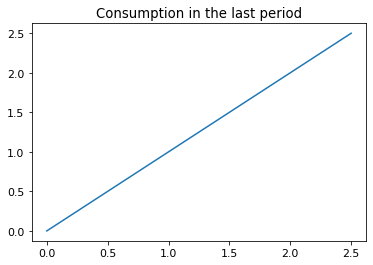

In [16]:
if __name__ == "__main__":

    plt.title('Consumption in the last period')
    plt.plot(a_init[:,1,1],
             σ_init[:,1,1])

### Without MA idiosyncratic income shock 

In [17]:
if __name__ == "__main__":


    ## solve the model for a range of ma(1) coefficients
    ### x!=0, adds the transitory shock an additional state variable 

    t_start = time()

    x_ls = [0.0]
    as_stars =[]
    σs_stars = []
    for i,x in enumerate(x_ls):
        lc.x = x
        as_star, σs_star = solve_model_backward_iter(lc,
                                                     a_init,
                                                     σ_init)
        as_stars.append(as_star)
        σs_stars.append(σs_star)



    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 29
objective model without stochastic risk
at work age of 28
objective model without stochastic risk
at work age of 27
objective model without stochastic risk
at work age of 26
objective model without stochastic risk
at work age of 25
objective model without stochastic risk
at work age of 24
objective model without stochastic risk
at work age of 23
objective model without stochastic risk
at work age of 22
objective model without stochastic risk
at work age of 21
objective model without stochastic risk
at work age of 20
objective model without stochastic risk
at work age of 19
objective model without stochastic risk
at work age of 18
objective model without stochastic risk
at work age of 17
objective model without stochastic risk
at work age of 16
objective model without stochastic risk
at work age of 15
objective model without stochastic risk
at work age of 14
objective model without stochastic risk
at work age of 13
objective model without stochastic risk
at work age of

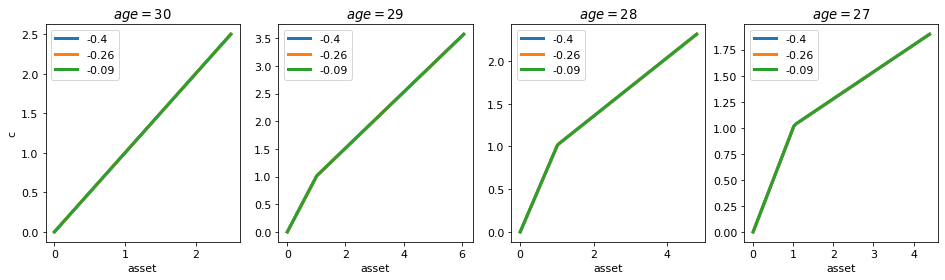

In [18]:
if __name__ == "__main__":


    ## plot c func at different age /asset grid
    years_left = [0,1,2,3]

    n_sub = len(years_left)

    eps_ls = [1,10,20]

    as_star = as_stars[0]
    σs_star =σs_stars[0]

    fig,axes = plt.subplots(1,n_sub,figsize=(4*n_sub,4))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age
        for y,eps in enumerate(eps_ls):
            axes[x].plot(as_star[i,:,eps,0],
                         σs_star[i,:,eps,0],
                         label = str(round(lc.eps_grid[eps],2)),
                         lw=3,
                        )
        axes[x].legend()
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'$age={}$'.format(age))

In [19]:
## interpolate consumption function on continuous s/eps grid 

#σs_list = []

#for i in range(lc.L):
#    this_σ= policyfuncMA(lc,
#                         as_star[i,:,:,0],
#                         σs_star[i,:,:,0])
#    σs_list.append(this_σ)

In [20]:
"""
## plot contour for policy function 

a_grid = np.linspace(0.00001,5,20)
eps_grid = lc.eps_grid
aa,epss = np.meshgrid(a_grid,
                      eps_grid)

σ_this = σs_list[3]
c_stars = σ_this(a_grid,
                 eps_grid)

cp = plt.contourf(aa,epss,
                  c_stars)
plt.title(r'$c$')
plt.xlabel('wealth')
plt.ylabel('ma income shock')
"""

"\n## plot contour for policy function \n\na_grid = np.linspace(0.00001,5,20)\neps_grid = lc.eps_grid\naa,epss = np.meshgrid(a_grid,\n                      eps_grid)\n\nσ_this = σs_list[3]\nc_stars = σ_this(a_grid,\n                 eps_grid)\n\ncp = plt.contourf(aa,epss,\n                  c_stars)\nplt.title(r'$c$')\nplt.xlabel('wealth')\nplt.ylabel('ma income shock')\n"

In [21]:
## the size of consumption function is  T x nb_a x nb_eps x nb_z 
if __name__ == "__main__":
    σs_star.shape

In [22]:
"""
## plot 3d consumption function 
#age,asset,inc_shk =σs_star[:,:,:,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(aa, epss, c_stars, zdir='z', c= 'red')
ax.set_xlabel('wealth')
ax.set_ylabel('inc shock')
ax.set_title('consumption at a certain age')
"""

"\n## plot 3d consumption function \n#age,asset,inc_shk =σs_star[:,:,:,0]\n\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nax.scatter(aa, epss, c_stars, zdir='z', c= 'red')\nax.set_xlabel('wealth')\nax.set_ylabel('inc shock')\nax.set_title('consumption at a certain age')\n"

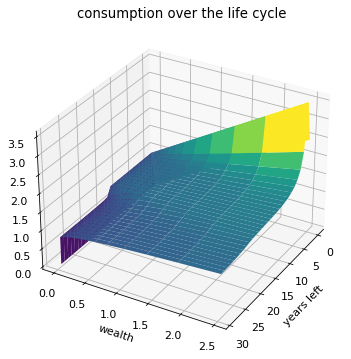

In [23]:
if __name__ == "__main__":

    ## plot 3d functions over life cycle 

    ages = np.array(range(as_star.shape[0]))
    asset = as_star[0,:,10,0]
    xx, yy = np.meshgrid(ages, asset)
    c_stars = σs_star[:,:,10,0].T

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, 
                         projection='3d')
    dem3d = ax.plot_surface(xx,
                            yy,
                            c_stars,
                            rstride=1, 
                            cstride=1,
                            cmap='viridis', 
                            edgecolor='none'
                           )
    ax.set_title('consumption over the life cycle')
    ax.set_xlabel('years left')
    ax.set_ylabel('wealth')
    ax.view_init(30, 30)

### Different ma persistence

- could be either individual unemployment state or macroeconomic state


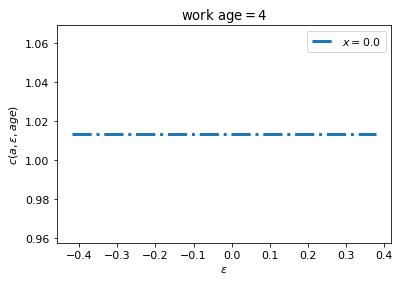

In [24]:
if __name__ == "__main__":
    at_age = 4
    at_asset_id = 20

    for i,x in enumerate(x_ls):
        this_σs_star = σs_stars[i]
        plt.plot(lc.eps_grid,
                 this_σs_star[lc.T-at_age,at_asset_id,:,0],
                 '-.',
                 label = r'$x={}$'.format(x),
                 lw=3)
    plt.legend(loc=0)
    plt.xlabel(r'$\epsilon$')
    plt.ylabel(r'$c(a,\epsilon,age)$')
    plt.title(r'work age$={}$'.format(at_age))

### With a Markov/persistent state: good versus bad 

In [25]:
if __name__ == "__main__":
    ## initialize another 
    lc_ar = LifeCycle(sigma_n=sigma_n,
                     sigma_eps = sigma_eps,
                     U=U0,
                     ρ=ρ,
                     R=R,
                     T=T,
                     L=L,
                     G=G,
                     β=β,
                     x=0.0,  ## shut down ma(1)
                     borrowing_cstr = borrowing_cstr,
                     b_y=1.0)

In [26]:
if __name__ == "__main__":


    ## solve the model for different persistence 
    t_start = time()


    ar_ls = [0.99]
    as_stars_ar=[]
    σs_stars_ar = []

    for i, ar in enumerate(ar_ls):

        ## tauchenize an ar1
        #σ = 0.18
        #constant = 0.00

        #mc = qe.markov.approximation.tauchen(ar, σ, b=constant, m=3, n=7)
        #z_ss_av = constant/(1-ar)
        #z_ss_sd = σ*np.sqrt(1/(1-ar**2))

        ## feed the model with a markov matrix of macro state 
        #lc_ar.z_val, lc_ar.P = mc.state_values, mc.P
        P = np.array([(0.8, 0.2),
                  (0.05, 0.95)])
        lc_ar.P = P

        ## initial guess
        k = len(lc_ar.s_grid)
        k2 =len(lc_ar.eps_grid)
        n = len(lc_ar.P)

        σ_init_ar = np.empty((k,k2,n))
        a_init_ar = np.empty((k,k2,n))

        for z in range(n):
            for j in range(k2):
                σ_init_ar[:,j,z] = 2*lc_ar.s_grid
                a_init_ar[:,j,z] = 2*lc_ar.s_grid

        ## solve the model 
        as_star_ar, σs_star_ar = solve_model_backward_iter(lc_ar,
                                                         a_init_ar,
                                                         σ_init_ar)
        as_stars_ar.append(as_star_ar)
        σs_stars_ar.append(σs_star_ar)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 29
objective model without stochastic risk
at work age of 28
objective model without stochastic risk
at work age of 27
objective model without stochastic risk
at work age of 26
objective model without stochastic risk
at work age of 25
objective model without stochastic risk
at work age of 24
objective model without stochastic risk
at work age of 23
objective model without stochastic risk
at work age of 22
objective model without stochastic risk
at work age of 21
objective model without stochastic risk
at work age of 20
objective model without stochastic risk
at work age of 19
objective model without stochastic risk
at work age of 18
objective model without stochastic risk
at work age of 17
objective model without stochastic risk
at work age of 16
objective model without stochastic risk
at work age of 15
objective model without stochastic risk
at work age of 14
objective model without stochastic risk
at work age of 13
objective model without stochastic risk
at work age of

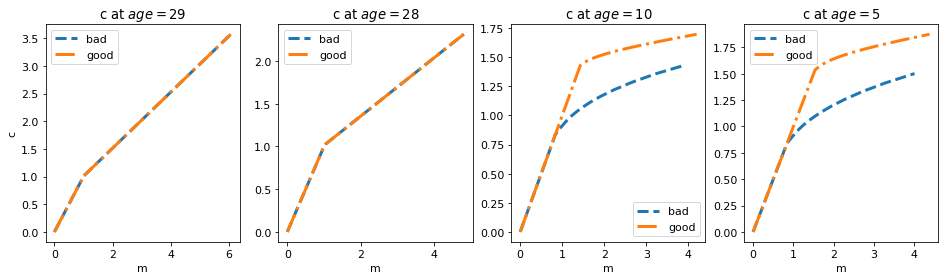

In [27]:
if __name__ == "__main__":


    ## compare two markov states good versus bad 

    years_left = [1,2,20,25]

    n_sub = len(years_left)


    eps_ls = [20]

    fig,axes = plt.subplots(1,n_sub,figsize=(4*n_sub,4))

    for x,year in enumerate(years_left):
        age = lc_ar.L-year
        i = lc_ar.L-age
        for y,eps in enumerate(eps_ls):
            axes[x].plot(as_stars_ar[0][i,:,y,0],
                         σs_stars_ar[0][i,:,y,0],
                         '--',
                         label ='bad',
                         lw=3)
            axes[x].plot(as_stars_ar[0][i,:,y,1],
                         σs_stars_ar[0][i,:,y,1],
                         '-.',
                         label ='good',
                         lw=3)
        axes[x].legend()
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c at $age={}$'.format(age))

### State-dependent risks 

In [33]:
if __name__ == "__main__":

    ## transition matrix between low and high risk state

    P = np.array([(0.5, 0.5),
                  (0.5, 0.5)])   # markov transition matricies 

    ss_P = cal_ss_2markov(P)
    prob_l = P[0,0]
    prob_h = P[0,1]

    ## keep average risks the same 
    sigma_n_l = 0.01*sigma_n
    sigma_n_h = np.sqrt((sigma_n**2 - prob_l*sigma_n_l**2)/prob_h)

    sigma_eps_l = 0.1*sigma_eps
    sigma_eps_h = np.sqrt((sigma_eps**2 - prob_l*sigma_eps_l**2)/prob_h)
    sigma_n_2mkv = np.array([sigma_n_l,sigma_n_h]) 
    sigma_eps_2mkv = np.array([sigma_eps_l,sigma_eps_h]) 


    b_y = 0.0  ## set the macro state loading to be zero, i.e. only risks differ across two states

In [34]:
if __name__ == "__main__":
    ## compute steady state 
    av_sigma_n = np.sqrt(np.dot(P[0,:],sigma_n_2mkv**2))
    av_sigma_eps = np.sqrt(np.dot(P[0,:],sigma_eps_2mkv**2))
    print('steady state is '+str(ss_P))
    print('transitory probability is '+str(P[0,:]))
    print('average permanent risk is '+str(av_sigma_n)+' compared to objective model '+str(sigma_n))
    print('average transitory risk is '+str(av_sigma_eps)+' compared to objective model '+str(sigma_eps))

steady state is [0.5 0.5]
transitory probability is [0.5 0.5]
average permanent risk is 0.05 compared to objective model 0.05
average transitory risk is 0.2 compared to objective model 0.2


In [35]:
if __name__ == "__main__":

    print('permanent risk state is '+str(sigma_n_2mkv))
    print('transitory risk state is '+str(sigma_eps_2mkv))

permanent risk state is [0.0005     0.07070891]
transitory risk state is [0.02       0.28213472]


In [36]:
if __name__ == "__main__":

    ## another model instance 

    lc_sv = LifeCycle(sigma_n = sigma_n,
                   sigma_eps = sigma_eps,
                   U=U,
                   ρ=ρ,
                   R=R,
                   T=T,
                   L=L,
                   G=G,
                   β=β,
                   x=x,
                   sigma_n_2mkv = sigma_n_2mkv,
                   sigma_eps_2mkv = sigma_eps_2mkv,
                   borrowing_cstr = borrowing_cstr,
                   b_y=b_y)

In [37]:
if __name__ == "__main__":

    ## solve the model for different transition matricies 

    t_start = time()

    P_ls = [P]
    as_stars_sv=[]
    σs_stars_sv = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        lc_sv.P = P

        ## initial guess
        k = len(lc_sv.s_grid)
        k2 =len(lc_sv.eps_grid)
        n = len(lc_sv.P)

        σ_init_sv = np.empty((k,k2,n))
        a_init_sv = np.empty((k,k2,n))

        for z in range(n):
            for j in range(k2):
                σ_init_sv[:,j,z] = 2*lc_sv.s_grid
                a_init_sv[:,j,z] = 2*lc_sv.s_grid

        ## solve the model 
        as_star_sv, σs_star_sv = solve_model_backward_iter(lc_sv,
                                                           a_init_sv,
                                                           σ_init_sv,
                                                           sv=True)
        as_stars_sv.append(as_star_sv)
        σs_stars_sv.append(σs_star_sv)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 29
objective model with stochastic risk
at work age of 28
objective model with stochastic risk
at work age of 27
objective model with stochastic risk
at work age of 26
objective model with stochastic risk
at work age of 25
objective model with stochastic risk
at work age of 24
objective model with stochastic risk
at work age of 23
objective model with stochastic risk
at work age of 22
objective model with stochastic risk
at work age of 21
objective model with stochastic risk
at work age of 20
objective model with stochastic risk
at work age of 19
objective model with stochastic risk
at work age of 18
objective model with stochastic risk
at work age of 17
objective model with stochastic risk
at work age of 16
objective model with stochastic risk
at work age of 15
objective model with stochastic risk
at work age of 14
objective model with stochastic risk
at work age of 13
objective model with stochastic risk
at work age of 12
objective model with stochastic risk
at work ag

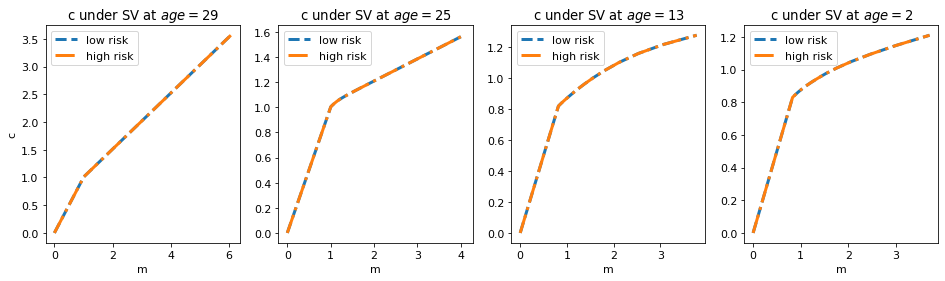

In [38]:
if __name__ == "__main__":
    ## compare two markov states low versus high risk 

    years_left = [1,5,17,28]

    n_sub = len(years_left)

    eps_id = 20

    fig,axes = plt.subplots(1,n_sub,figsize=(4*n_sub,4))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age
        axes[x].plot(as_stars_sv[0][i,:,eps_id,0], ## 0 indicates the low risk state 
                     σs_stars_sv[0][i,:,eps_id,0],
                     '--',
                     label ='low risk',
                     lw=3)
        axes[x].plot(as_stars_sv[0][i,:,eps_id,1], ## 1 indicates the high risk state 
                     σs_stars_sv[0][i,:,eps_id,1],
                     '-.',
                     label ='high risk',
                     lw=3)
        axes[x].legend()
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c under SV at $age={}$'.format(age))

### Comparison: objective and subjective risk perceptions

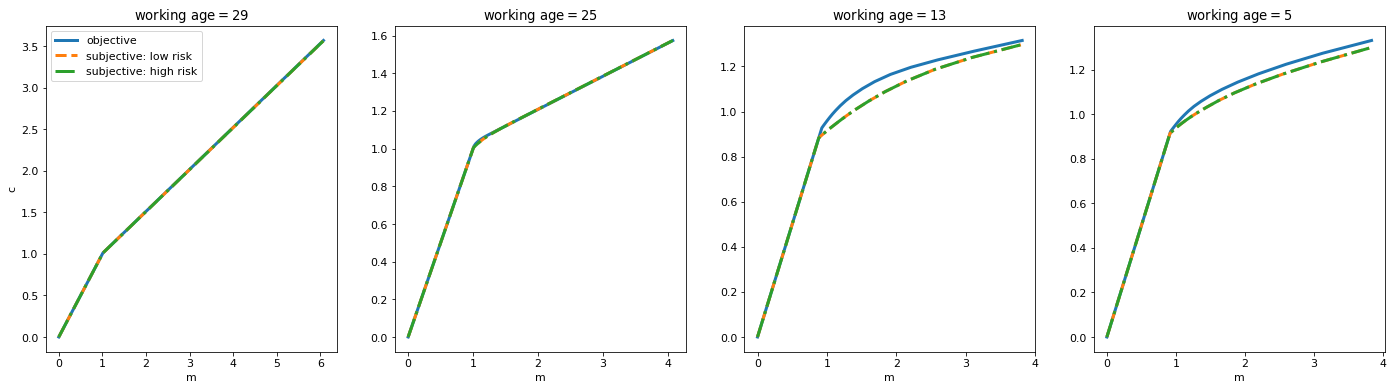

In [50]:
if __name__ == "__main__":


    ## compare subjective and objective models 
    years_left = [1,5,17,25]


    n_sub = len(years_left)

    eps_ls = [10]

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age
        for y,eps in enumerate(eps_ls):
            ## baseline: no ma shock 
            axes[x].plot(as_star[i,:,eps,0],
                         σs_star[i,:,eps,0],
                         label = 'objective',
                         lw=3)
            ## persistent 
            #axes[x].plot(as_stars_ar[0][i,:,y,0],
            #             σs_stars_ar[0][i,:,y,0],
            #             '--',
            #             label ='bad',
            #             lw=3)
            #axes[x].plot(as_stars_ar[0][i,:,y,1],
            #             σs_stars_ar[0][i,:,y,1],
            #             '-.',
            #             label ='good',
            #             lw=3)
             ## stochastic volatility 
            axes[x].plot(as_stars_sv[0][i,:,eps_id,0], ## 0 indicates the low risk state 
                         σs_stars_sv[0][i,:,eps_id,0],
                         '--',
                         label ='subjective: low risk',
                         lw=3)
            axes[x].plot(as_stars_sv[0][i,:,eps_id,1], ## 1 indicates the high risk state 
                         σs_stars_sv[0][i,:,eps_id,1],
                         '-.',
                         label ='subjective: high risk',
                         lw=3)
            ## countercyclical 
            #axes[x].plot(as_stars_cr[0][i,:,eps_id,0], ## 0 indicates the low risk state 
            #         σs_stars_cr[0][i,:,eps_id,0],
            #         '--',
            #         label ='sv: unemployed + high risk',
            #         lw=3)
            #axes[x].plot(as_stars_cr[0][i,:,eps_id,1], ## 1 indicates the high risk state 
            #             σs_stars_cr[0][i,:,eps_id,1],
            #             '-.',
            #             label ='sv:employed + low risk',
            #             lw=3)
            ## subjective 
            #axes[x].plot(as_br[i,:,eps,0],
            #             σs_br[i,:,eps,0],
            #             '*-',
            #             label = 'subjective:'+str(round(lc.eps_grid[eps],2)),
            #             lw=3)
            #axes[x].plot(as_star[i,:,eps,0],
            #             σs_star[i,:,eps,0],
            #             '--',
            #             label ='objective:'+str(round(lc.eps_grid[eps],2)),
            #             lw=3)

        axes[0].legend()
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'working age$={}$'.format(age))

    #plt.suptitle('Various Straight Lines',fontsize=20)

    fig.savefig('../Graphs/model/comparison1.png')

### With a Markov/persistent unemployment state

In [51]:
if __name__ == "__main__":


    ## transition matrix between emp and uemp

    ## transition probability during normal times of the economy 

    P_uemkv = np.array([(0.2, 0.8),
                        (0.2, 0.8)])   # markov transition matricies 

    #P_uemkv = np.array([(0.4, 0.6),
    #                    (0.05, 0.95)])   # markov transition matricies 

In [52]:
if __name__ == "__main__":


    ## initialize another 
    lc_uemkv = LifeCycle(sigma_n=sigma_n,
                         sigma_eps = sigma_eps,
                         U=U0,
                         ρ=ρ,
                         R=R,
                         T=T,
                         L=L,
                         G=G,
                         β=β,
                         x=0.0,  ## shut down ma(1)
                         borrowing_cstr = borrowing_cstr,
                         b_y = 0.0, ## markov state loading does not matter any more 
                         unemp_insurance = 0.3,
                         ue_markov = True)

In [53]:
if __name__ == "__main__":

    ## solve the model for different transition matricies of UE markov
    t_start = time()

    P_ls = [P_uemkv]
    as_stars_uemkv=[]
    σs_stars_uemkv = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        lc_uemkv.P = P

        ## initial guess
        k = len(lc_uemkv.s_grid)
        k2 =len(lc_uemkv.eps_grid)
        n = len(lc_uemkv.P)

        σ_init_uemkv = np.empty((k,k2,n))
        a_init_uemkv = np.empty((k,k2,n))

        for z in range(n):
            for j in range(k2):
                a_init_uemkv[:,j,z] = 2*lc_uemkv.s_grid
                σ_init_uemkv[:,j,z] = a_init_uemkv[:,j,z]


        ## solve the model 
        as_star_uemkv, σs_star_uemkv = solve_model_backward_iter(lc_uemkv,
                                                                 a_init_uemkv,
                                                                 σ_init_uemkv,
                                                                 sv = False)
        as_stars_uemkv.append(as_star_uemkv)
        σs_stars_uemkv.append(σs_star_uemkv)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 29
objective model without stochastic risk
at work age of 28
objective model without stochastic risk
at work age of 27
objective model without stochastic risk
at work age of 26
objective model without stochastic risk
at work age of 25
objective model without stochastic risk
at work age of 24
objective model without stochastic risk
at work age of 23
objective model without stochastic risk
at work age of 22
objective model without stochastic risk
at work age of 21
objective model without stochastic risk
at work age of 20
objective model without stochastic risk
at work age of 19
objective model without stochastic risk
at work age of 18
objective model without stochastic risk
at work age of 17
objective model without stochastic risk
at work age of 16
objective model without stochastic risk
at work age of 15
objective model without stochastic risk
at work age of 14
objective model without stochastic risk
at work age of 13
objective model without stochastic risk
at work age of

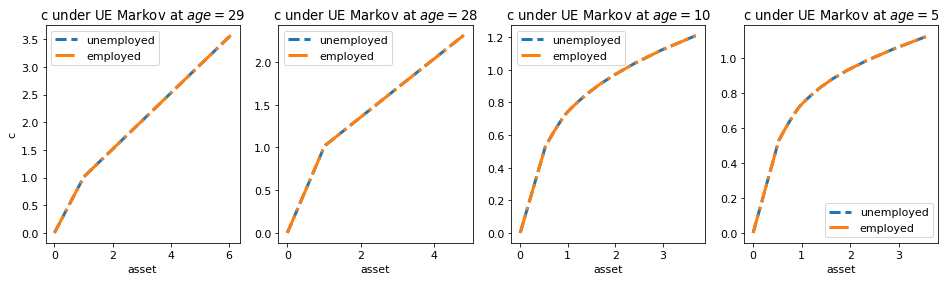

In [54]:
if __name__ == "__main__":


    ## compare two markov states of emp and uemp 

    years_left = [1,2,20,25]

    n_sub = len(years_left)

    eps_id = 20

    fig,axes = plt.subplots(1,n_sub,figsize=(4*n_sub,4))

    for x,year in enumerate(years_left):
        age = lc_uemkv.L-year
        i = lc_uemkv.L-age
        axes[x].plot(as_stars_uemkv[0][i,:,eps_id,0], ## 0 indicates the low risk state 
                     σs_stars_uemkv[0][i,:,eps_id,0],
                     '--',
                     label ='unemployed',
                     lw=3)
        axes[x].plot(as_stars_uemkv[0][i,:,eps_id,1], ## 1 indicates the high risk state 
                     σs_stars_uemkv[0][i,:,eps_id,1],
                     '-.',
                     label ='employed',
                     lw=3)
        axes[x].legend()
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c under UE Markov at $age={}$'.format(age))

### "Countercylical" risks

- unemployed perceive higher risks


In [39]:
if __name__ == "__main__":


    ss_P_cr= cal_ss_2markov(P_uemkv)
    prob_h_cr = P_uemkv[0,0]
    prob_l_cr = P_uemkv[0,1]

    ## keep average risks the same 
    sigma_n_l_cr = 0.1*sigma_n
    sigma_n_h_cr = np.sqrt((sigma_n**2 - prob_l_cr*sigma_n_l_cr**2)/prob_h_cr)

    sigma_eps_l_cr = 0.1*sigma_eps
    sigma_eps_h_cr = np.sqrt((sigma_eps**2 - prob_l_cr*sigma_eps_l_cr**2)/prob_h_cr)

    ### notice here I put high risk at the first!!!
    sigma_n_2mkv_cr= np.array([sigma_n_h_cr,sigma_n_l_cr**2])
    sigma_eps_2mkv_cr = np.array([sigma_eps_h_cr,sigma_eps_l_cr**2])

    ## again, zero loading from z
    b_y = 0.0

In [40]:

if __name__ == "__main__":
    ## compute steady state 
    av_sigma_n_cr = np.sqrt(np.dot(P_uemkv[0,:],sigma_n_2mkv_cr**2))
    av_sigma_eps_cr = np.sqrt(np.dot(P_uemkv[0,:],sigma_eps_2mkv_cr**2))
    print('steady state is '+str(ss_P_cr))
    print('transitory probability is '+str(P_uemkv[0,:]))

    print('average permanent risk is '+str(av_sigma_n_cr)+' compared to objective model '+str(sigma_n))
    print('average transitory risk is '+str(av_sigma_eps_cr)+' compared to objective model '+str(sigma_eps))

steady state is [0.2 0.8]
transitory probability is [0.2 0.8]
average permanent risk is 0.04979960341207549 compared to objective model 0.05
average transitory risk is 0.1991987148552922 compared to objective model 0.2


In [41]:
if __name__ == "__main__":


    ## model instance 
    lc_cr= LifeCycle(sigma_n = sigma_n,
                     sigma_eps = sigma_eps,
                     U=U0,
                     ρ=ρ,
                     P=P, 
                     R=R,
                     T=T,
                     L=L,
                     G=G,
                     β=β,
                     sigma_n_2mkv = sigma_n_2mkv_cr,   # different 
                     sigma_eps_2mkv = sigma_eps_2mkv_cr,  # different 
                     shock_draw_size = 30,
                     borrowing_cstr = borrowing_cstr,
                     x = x,  ## shut down ma(1)
                     b_y = b_y,
                     ue_markov = True)

In [42]:
if __name__ == "__main__":


    ## solve the model for different transition matricies 

    t_start = time()

    P_ls = [P_uemkv]
    as_stars_cr=[]
    σs_stars_cr = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        lc_cr.P = P

        ## initial guess
        k = len(lc_cr.s_grid)
        k2 =len(lc_cr.eps_grid)
        n = len(lc_cr.P)

        σ_init_cr = np.empty((k,k2,n))
        a_init_cr = np.empty((k,k2,n))

        for z in range(n):
            for j in range(k2):
                σ_init_cr[:,j,z] = 2*lc_cr.s_grid
                a_init_cr[:,j,z] = 2*lc_cr.s_grid

        ## solve the model 
        as_star_cr, σs_star_cr = solve_model_backward_iter(lc_cr,
                                                           a_init_cr,
                                                           σ_init_cr,
                                                           sv= True)
        as_stars_cr.append(as_star_cr)
        σs_stars_cr.append(σs_star_cr)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 29
objective model with stochastic risk
at work age of 28
objective model with stochastic risk
at work age of 27
objective model with stochastic risk
at work age of 26
objective model with stochastic risk
at work age of 25
objective model with stochastic risk
at work age of 24
objective model with stochastic risk
at work age of 23
objective model with stochastic risk
at work age of 22
objective model with stochastic risk
at work age of 21
objective model with stochastic risk
at work age of 20
objective model with stochastic risk
at work age of 19
objective model with stochastic risk
at work age of 18
objective model with stochastic risk
at work age of 17
objective model with stochastic risk
at work age of 16
objective model with stochastic risk
at work age of 15
objective model with stochastic risk
at work age of 14
objective model with stochastic risk
at work age of 13
objective model with stochastic risk
at work age of 12
objective model with stochastic risk
at work ag

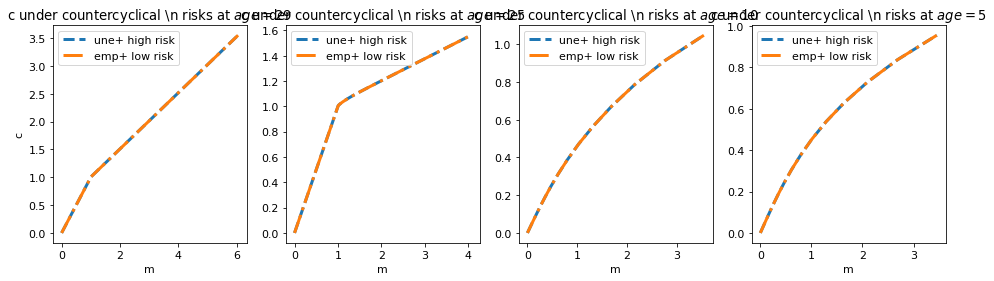

In [43]:
if __name__ == "__main__":


    ## compare two markov states low versus high risk 

    years_left = [1,5,20,25]

    n_sub = len(years_left)

    eps_id = 20

    fig,axes = plt.subplots(1,n_sub,figsize=(4*n_sub,4))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age
        axes[x].plot(as_stars_cr[0][i,:,eps_id,0], ## 0 indicates the low risk state 
                     σs_stars_cr[0][i,:,eps_id,0],
                     '--',
                     label ='une+ high risk',
                     lw=3)
        axes[x].plot(as_stars_cr[0][i,:,eps_id,1], ## 1 indicates the high risk state 
                     σs_stars_cr[0][i,:,eps_id,1],
                     '-.',
                     label ='emp+ low risk',
                     lw=3)
        axes[x].legend()
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c under countercyclical \n risks at $age={}$'.format(age))

### Objective and subject state-dependent profile

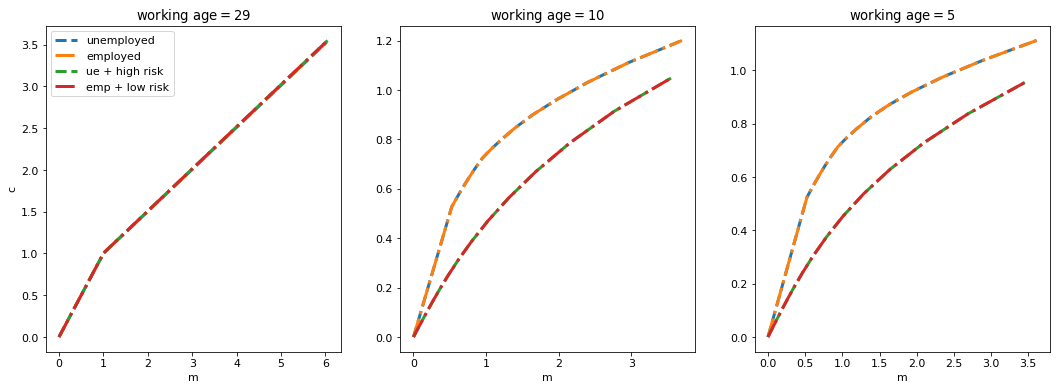

In [44]:
if __name__ == "__main__":

    ## compare subjective and objective models 

    years_left = [1,20,25]


    n_sub = len(years_left)

    eps_ls = [20]

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age
        for y,eps in enumerate(eps_ls):
            ## baseline: no ma shock 
            #axes[x].plot(as_star[i,:,eps,0],
            #             σs_star[i,:,eps,0],
            #             label = 'objective',
            #             lw=3)
            ## persistent 
            axes[x].plot(as_stars_uemkv[0][i,:,y,0],
                         σs_stars_uemkv[0][i,:,y,0],
                         '--',
                         label ='unemployed',
                         lw=3)
            axes[x].plot(as_stars_uemkv[0][i,:,y,1],
                         σs_stars_uemkv[0][i,:,y,1],
                         '-.',
                         label ='employed',
                         lw=3)
             ## stochastic volatility 
            #axes[x].plot(as_stars_sv[0][i,:,eps_id,0], ## 0 indicates the low risk state 
            #             σs_stars_sv[0][i,:,eps_id,0],
            #             '--',
            #             label ='sv:low risk',
            #             lw=3)
            #axes[x].plot(as_stars_sv[0][i,:,eps_id,1], ## 1 indicates the high risk state 
            #             σs_stars_sv[0][i,:,eps_id,1],
            #             '-.',
            #             label ='sv:high risk',
            #             lw=3)
            ## countercyclical 
            axes[x].plot(as_stars_cr[0][i,:,eps_id,0], ## 0 indicates the low risk state 
                     σs_stars_cr[0][i,:,eps_id,0],
                     '--',
                     label ='ue + high risk',
                     lw=3)
            axes[x].plot(as_stars_cr[0][i,:,eps_id,1], ## 1 indicates the high risk state 
                         σs_stars_cr[0][i,:,eps_id,1],
                         '-.',
                         label ='emp + low risk',
                         lw=3)
            # subjective 
            #axes[x].plot(as_br[i,:,eps,0],
            #             σs_br[i,:,eps,0],
            #             '*-',
            #             label = 'subjective:'+str(round(lc.eps_grid[eps],2)),
            #             lw=3)
            #axes[x].plot(as_star[i,:,eps,0],
            #             σs_star[i,:,eps,0],
            #             '--',
            #             label ='objective:'+str(round(lc.eps_grid[eps],2)),
            #             lw=3)

        axes[0].legend()
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'working age$={}$'.format(age))

    #plt.suptitle('Various Straight Lines',fontsize=20)

    fig.savefig('../Graphs/model/comparison2.png')

### Subjective perceptions 

In [45]:
if __name__ == "__main__":


    ## solve for subjective agent 
    ## agents extrapolate recent tarnsitory volatility to perceptions 

    t_start = time()


    as_br, σs_br = solve_model_backward_iter(lc,
                                             a_init,
                                             σ_init,
                                             br = True) ## bounded rationality is true 



    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 29
subjective model with stochastic risk
at work age of 28
subjective model with stochastic risk
at work age of 27
subjective model with stochastic risk
at work age of 26
subjective model with stochastic risk
at work age of 25
subjective model with stochastic risk
at work age of 24
subjective model with stochastic risk
at work age of 23
subjective model with stochastic risk
at work age of 22
subjective model with stochastic risk
at work age of 21
subjective model with stochastic risk
at work age of 20
subjective model with stochastic risk
at work age of 19
subjective model with stochastic risk
at work age of 18
subjective model with stochastic risk
at work age of 17
subjective model with stochastic risk
at work age of 16
subjective model with stochastic risk
at work age of 15
subjective model with stochastic risk
at work age of 14
subjective model with stochastic risk
at work age of 13
subjective model with stochastic risk
at work age of 12
subjective model with stochast

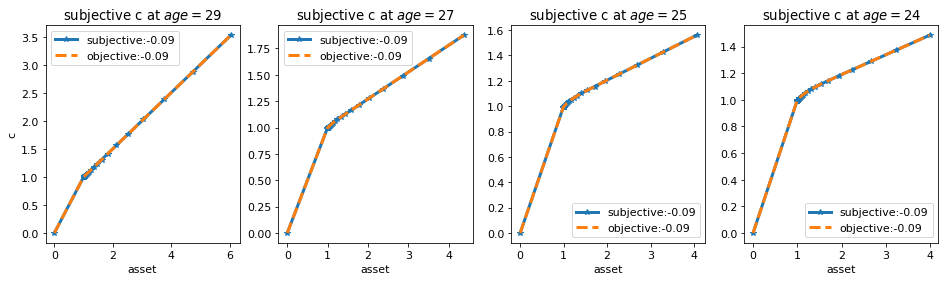

In [46]:
if __name__ == "__main__":


    ## compare subjective and objective model 
    years_left = [1,3,5,6]
    n_sub = len(years_left)

    eps_ls = [20]

    fig,axes = plt.subplots(1,n_sub,figsize=(4*n_sub,4))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age
        for y,eps in enumerate(eps_ls):
            axes[x].plot(as_br[i,:,eps,0],
                         σs_br[i,:,eps,0],
                         '*-',
                         label = 'subjective:'+str(round(lc.eps_grid[eps],2)),
                         lw=3)
            axes[x].plot(as_star[i,:,eps,0],
                         σs_star[i,:,eps,0],
                         '--',
                         label ='objective:'+str(round(lc.eps_grid[eps],2)),
                         lw=3)
        axes[x].legend()
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'subjective c at $age={}$'.format(age))

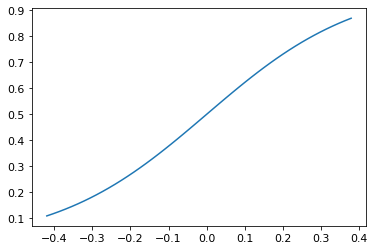

In [47]:
if __name__ == "__main__":


    x_sj = extrapolate(5, 
                       lc.x,
                       lc.eps_grid) ## sj: subjective 

    plt.plot(lc.eps_grid,x_sj)

Text(0.5, 1.0, 'subjectiv c at work age$=10$')

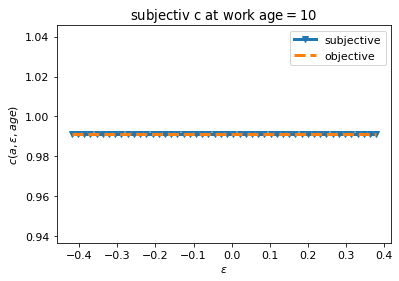

In [48]:
if __name__ == "__main__":


    at_age = 10
    at_asset_id = 15

    plt.plot(lc.eps_grid,
             σs_br[lc.T-at_age,at_asset_id,:,0],
                 'v-',
                 label = 'subjective',
                 lw=3)
    plt.plot(lc.eps_grid,
             σs_star[lc.T-at_age,at_asset_id,:,0],
             '--',
             label='objective',
             lw=3)
    plt.legend(loc=0)
    plt.xlabel(r'$\epsilon$')
    plt.ylabel(r'$c(a,\epsilon,age)$')
    plt.title(r'subjectiv c at work age$={}$'.format(at_age))

## Infinite horizon problem

In [49]:
if __name__ == "__main__":


    ## intialize a model instance

    inf_liv = LifeCycle(sigma_n=sigma_n,
                       sigma_eps = sigma_eps,
                       U=U,
                       ρ=ρ,
                       R=R,
                       T=T,
                       L=L,
                       β=β,
                       x=x,
                       theta=theta,
                       borrowing_cstr = borrowing_cstr,
                       b_y=b_y)


    ## initial consumption functions 

    k = len(inf_liv.s_grid)
    k2 =len(inf_liv.eps_grid)

    n = len(inf_liv.P)
    σ_init = np.empty((k,k2,n))
    a_init = np.empty((k,k2,n))

    for z in range(n):
        for j in range(k2):
            a_init[:,j,z] = inf_liv.s_grid
            σ_init[:,j,z] = 0.1*a_init[:,j,z]

    t_start = time()


    x_ls = [0.0]
    as_inf_stars =[]
    σs_inf_stars = []
    for i,x in enumerate(x_ls):

        ## set different ma parameters 
        inf_liv.x = x
        a_inf_star, σ_inf_star = solve_model_iter(inf_liv,
                                                  a_init,
                                                  σ_init)
        as_inf_stars.append(a_inf_star)
        σs_inf_stars.append(σ_inf_star)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   



    ## plot c func 

    eps_ls = [1,10,20]

    as_inf_star = as_inf_stars[0]
    σs_inf_star = σs_inf_stars[0]


    for y,eps in enumerate(eps_ls):
        plt.plot(as_inf_star[:,eps,0],
                 σs_inf_star[:,eps,0],
                 label = r'$\epsilon=$'+str(round(inf_liv.eps_grid[eps],2)),
                 lw=3
                )
        plt.legend()
        plt.xlabel('asset')
        plt.ylabel('c')
        plt.title('Inifite horizon solution')


KeyboardInterrupt: 

## Infinite horizon with adjustment inertia



In [ ]:
if __name__ == "__main__":


    ## intialize a model instance

    imp_adjust = LifeCycle(sigma_n=sigma_n,
                       sigma_eps = sigma_eps,
                       U=U,
                       ρ=ρ,
                       R=R,
                       T=T,
                       L=L,
                       β=β,
                       x=x,
                       theta=theta,
                       borrowing_cstr = borrowing_cstr,
                       b_y=b_y,
                       unemp_insurance = unemp_insurance,
                       adjust_prob = 0.6)

    ## initial consumption functions 

    k = len(imp_adjust.s_grid)
    k2 =len(imp_adjust.eps_grid)

    n = len(imp_adjust.P)
    σ_init = np.empty((k,k2,n))
    a_init = np.empty((k,k2,n))

    for z in range(n):
        for j in range(k2):
            a_init[:,j,z] = imp_adjust.s_grid
            σ_init[:,j,z] = 0.1*a_init[:,j,z]  ## c !=m because of infinite horizon

    t_start = time()


    x_ls = [0.0]
    as_imp_stars =[]
    σs_imp_stars = []
    for i,x in enumerate(x_ls):

        ## set different ma parameters 
        inf_liv.x = x
        a_imp_star, σ_imp_star = solve_model_iter(imp_adjust,
                                                  a_init,
                                                  σ_init)
        as_imp_stars.append(a_imp_star)
        σs_imp_stars.append(σ_imp_star)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   


    ## plot c func at different age /asset grid

    eps_ls = [10]

    as_imp_star = as_imp_stars[0]
    σs_imp_star = σs_imp_stars[0]

    for y,eps in enumerate(eps_ls):
        plt.plot(as_imp_star[:,eps,1],
                 σs_imp_star[:,eps,1],
                 '-',
                 label = 'imperfect adjustment',
                 lw=3
                )
        plt.plot(as_inf_star[:,eps,1],
                 σs_inf_star[:,eps,1],
                 '--',
                 label = 'perfect adjustment',
                 lw=3
                )
        plt.legend()
        plt.xlabel('asset')
        plt.ylabel('c')
        plt.title('Inifite horizon solution')

# 